Implementation of model to generate word2vec embeddings for telugu language. The model is trained on a corpus of wikipedia articles.

## Imports

In [1]:
%config Completer.use_jedi=False

In [2]:
import numpy as np

In [3]:
from tqdm.notebook import trange, tqdm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [5]:
import matplotlib.pyplot as plt

In [6]:
from itertools import chain
from collections import Counter
import string
import time
import re
import gc
import random
import math

In [7]:
torch.manual_seed(42)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

## Generate skipgrams

In [9]:
gc.collect()

115

In [10]:
# sample sentence to test the code
sentences = ['This is a notebook'.lower().split(), 'Another good notebook exists somewhere else as far as I know'.lower().split()]

In [11]:
# generate_word_contextword_pairs generate_word_contextword_pairs(sentence, n_of_ngram=3):
#     n = n_of_ngram
#     indx = int((n_of_ngram-1)/2)
#     all_word_context_pairs = []
#     for i in np.arange(len(sentence)-n + 1):
#         all_word_context_pairs.append([(sentence[i+indx], context_word) for context_word in sentence[i:i+indx]])
#         all_word_context_pairs.append([(sentence[i+indx], context_word) for context_word in sentence[i+indx+1:i+n]])
    
#     return list(chain.from_iterable(all_word_context_pairs))

# def generate_word_contextword_pairs(sentence, window_size=5): 
#     all_word_context_pairs = []
#     for i in np.arange(window_size, len(sentence)-window_size):
#         all_word_context_pairs.append([(sentence[i], context_word) for context_word in sentence[i-window_size:i]])
#         all_word_context_pairs.append([(sentence[i], context_word) for context_word in sentence[i+1:i+window_size+1]])
    
#     return list(chain.from_iterable(all_word_context_pairs))

def generate_word_contextword_pairs(sentence, window_size=5): 
    all_word_context_pairs = []
    
    for i, word in enumerate(sentence):
#         win_size = np.random.randint(low = 1, high = window_size+1 )
        win_size = window_size
        contexts = sentence[i-win_size:i] + sentence[i+1:i+win_size+1]
        all_word_context_pairs.append([(word, context_word) for context_word in contexts])
    return list(chain.from_iterable(all_word_context_pairs))

def generate_word_contextword_pairs_dynamic(sentence, window_size=5): 
    # window size is dynamic. window_size parameter is the maximum allowed window_size.
    # so for each word, win_size is uniformly sampled from [1, window_size]
    # Ref: Goldberg and Levy 2014 

    all_word_context_pairs = []
    
    for i, word in enumerate(sentence):
        win_size = np.random.randint(low = 1, high = window_size+1 )
#         win_size = window_size
        contexts = sentence[i-win_size:i] + sentence[i+1:i+win_size+1]
        all_word_context_pairs.append([(word, context_word) for context_word in contexts])
    return list(chain.from_iterable(all_word_context_pairs))

In [12]:
generate_word_contextword_pairs_dynamic(sentences[1],2)

[('another', 'good'),
 ('good', 'another'),
 ('good', 'notebook'),
 ('notebook', 'good'),
 ('notebook', 'exists'),
 ('exists', 'good'),
 ('exists', 'notebook'),
 ('exists', 'somewhere'),
 ('exists', 'else'),
 ('somewhere', 'notebook'),
 ('somewhere', 'exists'),
 ('somewhere', 'else'),
 ('somewhere', 'as'),
 ('else', 'somewhere'),
 ('else', 'as'),
 ('as', 'somewhere'),
 ('as', 'else'),
 ('as', 'far'),
 ('as', 'as'),
 ('far', 'as'),
 ('far', 'as'),
 ('as', 'as'),
 ('as', 'far'),
 ('as', 'i'),
 ('as', 'know'),
 ('i', 'far'),
 ('i', 'as'),
 ('i', 'know'),
 ('know', 'as'),
 ('know', 'i')]

In [13]:
generate_word_contextword_pairs(sentences[1],2)

[('another', 'good'),
 ('another', 'notebook'),
 ('good', 'notebook'),
 ('good', 'exists'),
 ('notebook', 'another'),
 ('notebook', 'good'),
 ('notebook', 'exists'),
 ('notebook', 'somewhere'),
 ('exists', 'good'),
 ('exists', 'notebook'),
 ('exists', 'somewhere'),
 ('exists', 'else'),
 ('somewhere', 'notebook'),
 ('somewhere', 'exists'),
 ('somewhere', 'else'),
 ('somewhere', 'as'),
 ('else', 'exists'),
 ('else', 'somewhere'),
 ('else', 'as'),
 ('else', 'far'),
 ('as', 'somewhere'),
 ('as', 'else'),
 ('as', 'far'),
 ('as', 'as'),
 ('far', 'else'),
 ('far', 'as'),
 ('far', 'as'),
 ('far', 'i'),
 ('as', 'as'),
 ('as', 'far'),
 ('as', 'i'),
 ('as', 'know'),
 ('i', 'far'),
 ('i', 'as'),
 ('i', 'know'),
 ('know', 'as'),
 ('know', 'i')]

## Telugu wikipedia corpus

In [14]:
te_corpus = open('Data/te_wiki_cleaned_dedup.txt').read().splitlines()
# Remove digits
te_corpus = [re.sub(r'\d+', '',line).strip() for line in te_corpus] 
# Remove all space/tab/newline/half-space characters
te_corpus = [re.sub(r'\u200c', ' ', line) for line in te_corpus]
print(f'Length of corpus: {len(te_corpus)}')

Length of corpus: 990983


In [15]:
print(te_corpus[:10])

['గుంటూరు జిల్లా, ఆంధ్రప్రదేశ్ లోని కోస్తా ప్రాంతంలో ఒక జిల్లా.', 'రాష్ట్ర రాజధాని అమరావతి గుంటూరు జిల్లాలో వుంది.', 'కృష్ణా నది, సముద్రంలో కలిసేవరకు, ఎడమవైపు కృష్ణాజిల్లా, కుడివైపు గుంటూరు జిల్లాను వేరుచేస్తుంది.', 'ఈ జిల్లా , చ. కి. మీ. ల విస్తీర్ణంలో వ్యాపించి, ,, ( గణన) జనాభా కలిగి రాష్ట్రంలో రెండవ పెద్ద జనాభాగల జిల్లాగా గుర్తింపు పొందింది.', 'ఈ జిల్లాకు అతి పురాతన చరిత్ర ఉంది.', 'మౌర్యులు, శాతవాహనులు, పల్లవులు, చాళుక్యులు, కాకతీయులు, రెడ్డి రాజులు, విజయనగర రాజులు పరిపాలించారు.', 'పల్నాటి యుద్ధం ఈ జిల్లాలోని కారంపూడిలో జరిగింది.', 'మొగలు సామ్రాజ్యం నిజాం పాలన, ఈస్ట్ ఇండియా కంపెనీ, ఆ తరువాత మద్రాసు ప్రసిడెన్సీలో భాగమైంది.', 'స్వాతంత్ర్య సమరంలో పెదనందిపాడు పన్నుల ఎగవేత, సైమన్ కమిషన్ ఉద్యమం లాంటి ఎన్నో చారిత్రక ఘట్టాలు ఈ జిల్లాలో జరిగాయి.', 'స్వాతంత్ర్యం తరువాత ఆంధ్రరాష్ట్రంలో, ఆ తదుపరి ఆంధ్రప్రదేశ్ లో భాగమైంది.']


In [16]:
# Remove punctuation
te_corpus = [line.translate(str.maketrans('', '', string.punctuation)) for line in te_corpus] 

In [17]:
# Remove empty lines and lowercasing
te_corpus = [line.lower() for line in te_corpus if line] 

In [18]:
# Remove lines with less than 15 words
te_corpus = [line.strip() for line in te_corpus if len(line.strip().split()) >= 15]
print(f'Length of corpus: {len(te_corpus)}')

Length of corpus: 202620


In [19]:
# Tokenize
te_corpus = [line.strip().split() for line in te_corpus]

In [20]:
print(te_corpus[:10])

[['ఈ', 'జిల్లా', 'చ', 'కి', 'మీ', 'ల', 'విస్తీర్ణంలో', 'వ్యాపించి', 'గణన', 'జనాభా', 'కలిగి', 'రాష్ట్రంలో', 'రెండవ', 'పెద్ద', 'జనాభాగల', 'జిల్లాగా', 'గుర్తింపు', 'పొందింది'], ['స్వాతంత్ర్య', 'సమరంలో', 'పెదనందిపాడు', 'పన్నుల', 'ఎగవేత', 'సైమన్', 'కమిషన్', 'ఉద్యమం', 'లాంటి', 'ఎన్నో', 'చారిత్రక', 'ఘట్టాలు', 'ఈ', 'జిల్లాలో', 'జరిగాయి'], ['ప్రసిద్ధ', 'బౌద్ధ', 'తత్వవేత్త', 'అయిన', 'ఆచార్య', 'నాగార్జునుడు', 'ఈ', 'ప్రాంతం', 'వాడు', 'క్రీ', 'పూ', 'నాటికే', 'ఈ', 'ప్రాంతంలో', 'అభ్రకం', 'మైకా', 'ను', 'కనుగొనబడింది'], ['శాసన', 'ఆధారాలను', 'బట్టి', 'కుబేర', 'రాజు', 'క్రీ', 'పూ', 'ప్రాంతంలో', 'భట్టిప్రోలును', 'పరిపాలించాడని', 'ఆ', 'తరువాత', 'సాల', 'రాజులు', 'పాలించారని', 'తెలుస్తుంది'], ['వివిధ', 'కాలాల్లో', 'గుంటూరును', 'పరిపాలించిన', 'వంశాలలో', 'ప్రముఖమైనవి', 'శాతవాహనులు', 'ఇక్ష్వాకులు', 'పల్లవులు', 'ఆనంద', 'గోత్రీకులు', 'విష్ణుకుండినులు', 'చాళుక్యులు', 'చోళులు', 'కాకతీయులు', 'రెడ్డి', 'రాజులు', 'విజయనగర', 'రాజులు', 'కుతుబ్', 'షాహీలు'], ['ఆవి', 'దాచేపల్లి', 'ప్రత్తిపాడు', 'మార్టూరు', 'ఠుంఠురుకొర', 'మ

In [21]:
unigram_freq = dict(Counter(list(chain.from_iterable(te_corpus))))
print(f'Number of tokens: {len(unigram_freq)}')

Number of tokens: 478640


In [22]:
min_occurrences = 50
unigram_freq_filtered ={}
[unigram_freq_filtered.update({key:unigram_freq[key]}) for key in unigram_freq.keys() if unigram_freq[key]>min_occurrences]
print(f'Number of tokens: {len(unigram_freq_filtered)}')

Number of tokens: 8915


In [23]:
list(unigram_freq_filtered.items())[:10]

[('ఈ', 38562),
 ('జిల్లా', 6723),
 ('చ', 571),
 ('కి', 45451),
 ('మీ', 43087),
 ('ల', 2399),
 ('విస్తీర్ణంలో', 145),
 ('వ్యాపించి', 134),
 ('గణన', 52),
 ('జనాభా', 2201)]

In [24]:
# Vocabulary
vocab = list(unigram_freq_filtered.keys())
# vocab.insert(0, '<unk>')
vocab_size = len(vocab)

In [25]:
# dictionaries to help convert between index and word
word_to_idx = {word: i for i, word in enumerate(vocab)}
indx_to_word = {i: word for i, word in enumerate(vocab)}

In [26]:
# Handle low freq words
te_corpus_N = []
for sentence in tqdm(te_corpus,total=len(te_corpus)):
    sent_N = []
    for word in sentence:
        if word in vocab:
            sent_N.append(word) 
#         else:
#             sent_N.append('<unk>') # remove them; ref: Goldberg and Levy 2014
    te_corpus_N.append(sent_N)

  0%|          | 0/202620 [00:00<?, ?it/s]

In [27]:
len(te_corpus), len(te_corpus_N)

(202620, 202620)

In [28]:
vocab_freq = torch.Tensor(list(Counter(list(chain.from_iterable(te_corpus_N))).values()))

In [29]:
sampling_dist = vocab_freq**0.75

In [30]:
sampling_dist = sampling_dist/sampling_dist.sum()

In [31]:
data = list(chain.from_iterable([generate_word_contextword_pairs(sentence,5) for sentence in te_corpus_N]))
# data = list(chain.from_iterable([generate_word_contextword_pairs_dynamic(sentence,5) for sentence in te_corpus_N]))
print(f'A few word-context pairs: {data[0:10]}')
data = [(word_to_idx[a], word_to_idx[b]) for a,b in data]
print(f'A few word-context pairs interms of vocab indices: {data[0:10]}')

A few word-context pairs: [('ఈ', 'జిల్లా'), ('ఈ', 'చ'), ('ఈ', 'కి'), ('ఈ', 'మీ'), ('ఈ', 'ల'), ('జిల్లా', 'చ'), ('జిల్లా', 'కి'), ('జిల్లా', 'మీ'), ('జిల్లా', 'ల'), ('జిల్లా', 'విస్తీర్ణంలో')]
A few word-context pairs interms of vocab indices: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]


In [32]:
BATCH_SIZE = 1024*4
dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [33]:
class SkipGramNegativeSampling(nn.Module):
    
    def __init__(self,embedding_size, vocab_size, num_neg_samples=5, sampling_weights=None):
        super(SkipGramNegativeSampling, self).__init__()
        self.input_embedding = nn.Embedding(vocab_size,embedding_size)
        self.output_embedding = nn.Embedding(vocab_size, embedding_size)
        
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size      
        self.num_neg_samples = num_neg_samples
        if sampling_weights is not None:
            self.sampling_weights = sampling_weights
        else:
            self.sampling_weights = torch.ones(self.vocab_size)/self.vocab_size
            
        
    def forward(self, inputs, outputs):
        # Dont need forward. Computing loss dirictly is simpler
#         raise NotImplementedError
        out = self.input_embedding(inputs)* self.output_embedding(outputs)
#         for _ in out.shape[1:]:
#             out= out.sum(1)
#         return out
        return out.sum(1)
    
    def negativeSampling(self, num_samples):        
        # returns indices of sampled words
        return torch.multinomial(self.sampling_weights, num_samples, replacement=True)
    
    def loss(self, inputs, outputs, negative_samples):
        input_em = self.input_embedding(inputs)
        output_em = self.output_embedding(outputs)
        neg_samples_em = self.output_embedding(negative_samples)

        loss_val_term1 = F.logsigmoid(torch.sum(input_em* output_em, dim=1))
        loss_val_term2 = torch.sum(F.logsigmoid(-torch.sum((input_em.unsqueeze(1).repeat((1,self.num_neg_samples,1))*neg_samples_em), dim=2)), dim=1)
        
        return -torch.sum(loss_val_term1 + loss_val_term2)

    
    
    

In [34]:
# for future use
torch.save(te_corpus_N,'Data/teWikiCorpus.pkl')

In [35]:
# Find optimal Learning rate 
def find_learning_rate(model, dataloader, initial_lr = 1e-5, max_lr = 1e2,  num_lr_finder_steps=100):


    # Free memory
    gc.collect()
    torch.cuda.empty_cache()

    # training mode
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr = initial_lr)
    fac= np.exp((1/num_lr_finder_steps)*np.log(max_lr/initial_lr))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda epoch: fac**(epoch+1))
    # scheduler = None
    iter_dataloader = iter(dataloader)
    lr_list = []
    for iteration in trange(num_lr_finder_steps):
        
        word_indx, context_word_indx  = next(iter_dataloader)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # compute loss
        inp = word_indx.to(device)
        outp = context_word_indx.to(device)
        negative_samples = model.negativeSampling(model.num_neg_samples*inp.shape[0]) # batch size = inputs.shape[0]
        negative_samples = negative_samples.reshape(inp.shape[0],model.num_neg_samples)
        negative_samples = negative_samples.to(device)

        loss = model.loss(inp, outp,negative_samples)
        
        lr_list.append([scheduler.get_last_lr()[0],loss.item() ])
        
        # backward pass
        loss.backward()
        
        # optimization step
        optimizer.step()
        
        # scheduler step
        scheduler.step()
        
    return np.array(lr_list)
        

In [36]:
# Remember to run lr_finder on just initialised model
model = SkipGramNegativeSampling(embedding_size= 100, vocab_size=vocab_size, num_neg_samples= 5, sampling_weights=sampling_dist)
lr_list = find_learning_rate(model, dataloader, initial_lr=1e-5,max_lr=1e1,num_lr_finder_steps=500)

  0%|          | 0/500 [00:00<?, ?it/s]

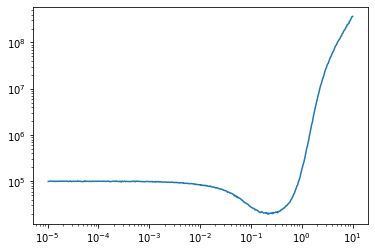

In [37]:
plt.loglog(lr_list[:,0], lr_list[:,1])

In [38]:
optimal_lr = 0.005 # 0.01 and above leading to divergence

In [39]:
# Instantiate model
model = SkipGramNegativeSampling(embedding_size= 100, vocab_size=vocab_size, num_neg_samples= 5, sampling_weights=sampling_dist)

In [40]:
# Train
LEARNING_RATE = optimal_lr
NUM_EPOCHS = 30
LOG_INTERVAL = 1

# Free memory
gc.collect()
torch.cuda.empty_cache()

start = time.time() # timer

# training
model = model.to(device)
model.train()

loss_values =[]

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=LEARNING_RATE, 
                                                steps_per_epoch=len(dataloader), 
                                                anneal_strategy = 'linear',
                                                epochs=NUM_EPOCHS,
                                                div_factor = 10,
                                                final_div_factor = 1000,
                                                pct_start = 0.4,
                                                three_phase = True,
                                               )
# scheduler = None


for epoch in trange(NUM_EPOCHS):
    loss_total = 0
    
    for word_indx, context_word_indx in tqdm(dataloader, total=len(dataloader)):
         
        # zero the gradients
        optimizer.zero_grad()     

        # compute loss
        inp = word_indx.to(device)
        outp = context_word_indx.to(device)
        negative_samples = model.negativeSampling(model.num_neg_samples*inp.shape[0]) # batch size = inputs.shape[0]
        negative_samples = negative_samples.reshape(inp.shape[0],model.num_neg_samples)
        negative_samples = negative_samples.to(device)
        
        loss = model.loss(inp, outp,negative_samples)
        loss_total += loss.item()

        # backward pass
        loss.backward()
        
        # optimization step
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
    loss_values.append(loss_total)
            
    if epoch%LOG_INTERVAL ==0:
        print("Epoch " + str(epoch) + " done. Loss: " + str(loss_total))
#         torch.save(model, 'saved_model.pkl')
        
print("Epoch " + str(epoch) + " done. Loss: " + str(loss_total))
elapsed = time.time() - start
print(f"Model trained for {NUM_EPOCHS} in {elapsed/60: .2f} minutes")


torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_values': loss_values,
        }, f'Word2Vec_te_{NUM_EPOCHS}_epochs.pt')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 0 done. Loss: 262760135.93164062


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 1 done. Loss: 73876308.12158203


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 2 done. Loss: 47793887.3347168


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 3 done. Loss: 40613047.87561035


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 4 done. Loss: 38765282.25817871


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 5 done. Loss: 38170908.56384277


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 6 done. Loss: 37904804.677612305


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 7 done. Loss: 37770416.11621094


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 8 done. Loss: 37733812.841308594


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 9 done. Loss: 37747191.46411133


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 10 done. Loss: 37793030.99963379


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 11 done. Loss: 37870642.029296875


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 12 done. Loss: 37880494.10180664


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 13 done. Loss: 37742449.669921875


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 14 done. Loss: 37613395.802978516


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 15 done. Loss: 37486634.61291504


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 16 done. Loss: 37354301.186035156


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 17 done. Loss: 37224589.146118164


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 18 done. Loss: 37093519.99926758


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 19 done. Loss: 36962673.9284668


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 20 done. Loss: 36823727.65649414


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 21 done. Loss: 36695964.10021973


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 22 done. Loss: 36559310.03149414


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 23 done. Loss: 36417930.14135742


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 24 done. Loss: 36309929.19592285


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 25 done. Loss: 36272442.28955078


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 26 done. Loss: 36236087.76049805


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 27 done. Loss: 36201281.384887695


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 28 done. Loss: 36167888.80859375


  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch 29 done. Loss: 36132809.97924805
Epoch 29 done. Loss: 36132809.97924805
Model trained for 30 in  37.48 minutes


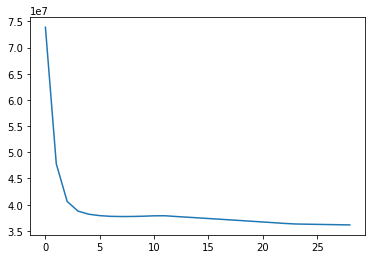

In [41]:
plt.plot(loss_values[1:])

In [42]:
model.to('cpu')
model.eval()
em = nn.Embedding.from_pretrained(model.input_embedding.weight, freeze=True)
word_emb = em.weight

In [43]:
def cosineSimilarity(w1, w2):
    return np.dot(w1,w2)/(np.linalg.norm(w1) * np.linalg.norm(w2))

In [44]:
def findSimilar(word, word_emb, k=5):
    word_vec = word_emb[word_to_idx[word]]

    sim = np.zeros(word_emb.shape[0])
    for i,row in enumerate(word_emb):
        sim[i] = cosineSimilarity(word_vec.numpy(), row.numpy())
    val,ind = torch.topk(torch.Tensor(sim), k+1)
    return [(vocab[ind[i]], val[i].item() )for i in np.arange(1, len(ind))]

# def findSimilar(word, word_emb, k=5):
#     word_vec = word_emb[word_to_idx[word]]
#     sim = torch.zeros(word_emb.shape[0])
#     for i,row in enumerate(word_emb):
#         sim[i] = torch.dot(word_vec, row)
#     val,ind = torch.topk(sim, k)
#     return [indx_to_word[i] for i in ind.numpy()]
# #     return ind.numpy()

In [45]:
findSimilar('దక్షిణ', word_emb, 10)

[('ఉత్తర', 0.8820783495903015),
 ('తూర్పు', 0.8115730881690979),
 ('ఆగ్నేయ', 0.7735185027122498),
 ('పశ్చిమ', 0.7714394330978394),
 ('ఈశాన్య', 0.7370826601982117),
 ('నైరుతి', 0.6693284511566162),
 ('సరిహద్దులో', 0.6219167113304138),
 ('భారతదేశం', 0.5986282229423523),
 ('వాయవ్య', 0.596453845500946),
 ('తూర్పున', 0.5913439393043518)]

In [46]:
findSimilar('పంటలు', word_emb, 10)

[('వరి', 0.6491200923919678),
 ('పంట', 0.6468113660812378),
 ('కూరగాయలు', 0.5941598415374756),
 ('మొక్కజొన్న', 0.5630755424499512),
 ('సాగు', 0.5612453818321228),
 ('రైతులు', 0.5576823353767395),
 ('వేరుశనగ', 0.5540198087692261),
 ('జొన్న', 0.5502128005027771),
 ('చెరకు', 0.5467171669006348),
 ('పంటలను', 0.5452612638473511)]

In [47]:
findSimilar('ఎనిమిది', word_emb, 10)

[('పది', 0.7577728033065796),
 ('తొమ్మిది', 0.6858631372451782),
 ('ఆరు', 0.6722651124000549),
 ('ఏడు', 0.6405187845230103),
 ('నాలుగు', 0.6318432688713074),
 ('ఇరవై', 0.6151851415634155),
 ('అయిదు', 0.597472608089447),
 ('పన్నెండు', 0.5868387222290039),
 ('అరవై', 0.5862650275230408),
 ('ఐదు', 0.5674272775650024)]

In [48]:
findSimilar('తక్కువ', word_emb, 10)

[('ఎక్కువ', 0.802049994468689),
 ('కంటే', 0.7693387866020203),
 ('తక్కువగా', 0.7488549947738647),
 ('అధిక', 0.7403759956359863),
 ('చాలా', 0.6861771941184998),
 ('ఎక్కువగా', 0.6174743175506592),
 ('ఉష్ణోగ్రత', 0.601702094078064),
 ('మొత్తంలో', 0.5920453071594238),
 ('సాంద్రత', 0.5896340608596802),
 ('పోలిస్తే', 0.5876764059066772)]

In [49]:
findSimilar('గ్రామం', word_emb, 10)

[('జనగణన', 0.5437976717948914),
 ('గ్రామానికి', 0.5251233577728271),
 ('మండలంలోని', 0.5204244256019592),
 ('ఇళ్లతో', 0.514874279499054),
 ('గ్రామ', 0.5063568949699402),
 ('మండలానికి', 0.4992063343524933),
 ('పట్టణం', 0.48425593972206116),
 ('గ్రామములో', 0.46907129883766174),
 ('రాజుపాలెం', 0.46144938468933105),
 ('గ్రామాల', 0.45734643936157227)]